# 🍎🥕 Mini-Projet : Reconnaissance Robuste de Fruits & Légumes
---
### 🎓 **Module :** Reconnaissance d'Images
**Étudiant :** SKHIRI HABIB

**Niveau :** 5ème Année Ingénieur



In [ ]:
!pip install kaggle

In [ ]:
import os
import json
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import files
from tqdm import tqdm

# Bibliothèques ML & Image Processing
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from skimage.feature import graycomatrix, graycoprops

In [ ]:
from google.colab import files
files.upload()
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d kritikseth/fruit-and-vegetable-image-recognition
!unzip fruit-and-vegetable-image-recognition.zip

Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/kritikseth/fruit-and-vegetable-image-recognition
License(s): CC0-1.0
 99% 1.96G/1.98G [00:18<00:00, 38.8MB/s]
100% 1.98G/1.98G [00:18<00:00, 113MB/s] 
Archive:  fruit-and-vegetable-image-recognition.zip
  inflating: test/apple/Image_1.jpg  
  inflating: test/apple/Image_10.jpg  
  inflating: test/apple/Image_2.jpg  
  inflating: test/apple/Image_3.jpg  
  inflating: test/apple/Image_4.jpg  
  inflating: test/apple/Image_5.jpg  
  inflating: test/apple/Image_6.JPG  
  inflating: test/apple/Image_7.jpg  
  inflating: test/apple/Image_8.jpg  
  inflating: test/apple/Image_9.jpg  
  inflating: test/banana/Image_1.jpg  
  inflating: test/banana/Image_10.jpg  
  inflating: test/banana/Image_2.jpg  
  inflating: test/banana/Image_3.jpg  
  inflating: test/banana/Image_4.jpg  
  inflating: test/banana/Image_5.jpg  
  inflating: test/banana/Image_6.jpg  
  inflating: test/banana/Image_8.jpg  
  inflating: test/banana

In [ ]:
TRAIN_DIR = 'train'
TEST_DIR = 'test'
classes = sorted(os.listdir(TRAIN_DIR))
print(f"\n📂 Classes détectées ({len(classes)}) : {classes}")


📂 Classes détectées (36) : ['apple', 'banana', 'beetroot', 'bell pepper', 'cabbage', 'capsicum', 'carrot', 'cauliflower', 'chilli pepper', 'corn', 'cucumber', 'eggplant', 'garlic', 'ginger', 'grapes', 'jalepeno', 'kiwi', 'lemon', 'lettuce', 'mango', 'onion', 'orange', 'paprika', 'pear', 'peas', 'pineapple', 'pomegranate', 'potato', 'raddish', 'soy beans', 'spinach', 'sweetcorn', 'sweetpotato', 'tomato', 'turnip', 'watermelon']


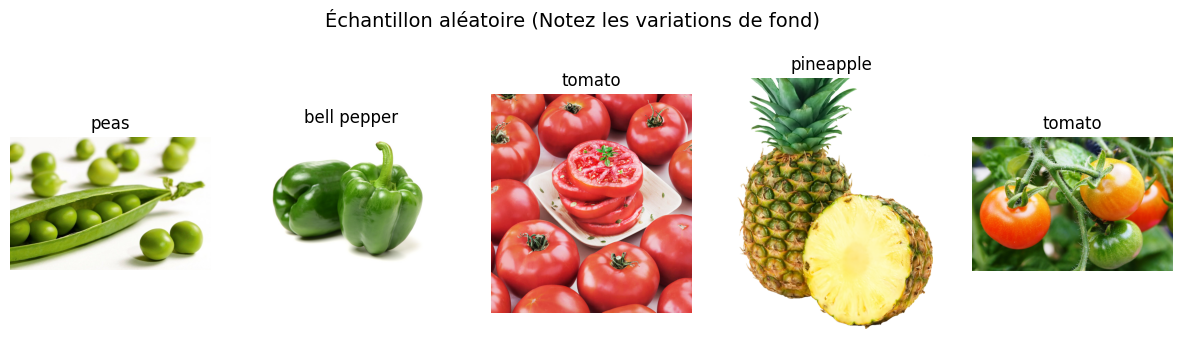

In [ ]:
def show_examples():
    plt.figure(figsize=(15, 4))
    plt.suptitle("Échantillon aléatoire (Notez les variations de fond)", fontsize=14)
    for i in range(5):
        cls = np.random.choice(classes)
        path = os.path.join(TRAIN_DIR, cls)
        img_name = np.random.choice(os.listdir(path))
        img = cv2.imread(os.path.join(path, img_name))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(1, 5, i+1)
        plt.imshow(img)
        plt.title(cls)
        plt.axis('off')
    plt.show()

show_examples()

Voici un aperçu des données. Vous voyez que les fonds changent, la lumière change. C'est pour ça qu'on ne peut pas comparer les pixels un par un, il faut extraire des caractéristiques plus intelligentes

In [ ]:
# ==============================================================================
# ÉTAPE 2 : EXTRACTION DE CARACTÉRISTIQUES
# ==============================================================================
def extract_features(img_bgr):
    if img_bgr is None: return None
    img = cv2.resize(img_bgr, (128, 128))
    features = []

    # 1. COULEUR (HSV)
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    hist_h = cv2.calcHist([hsv], [0], None, [8], [0, 180])
    hist_s = cv2.calcHist([hsv], [1], None, [8], [0, 256])
    cv2.normalize(hist_h, hist_h)
    cv2.normalize(hist_s, hist_s)
    features.extend(hist_h.flatten())
    features.extend(hist_s.flatten())

    # 2. TEXTURE (Haralick / GLCM)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    glcm = graycomatrix(gray, [1], [0], levels=256, symmetric=True, normed=True)
    for prop in ['contrast', 'homogeneity', 'energy', 'correlation']:
        features.append(graycoprops(glcm, prop).mean())

    # 3. FORME (Moments de Hu)
    _, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    moments = cv2.moments(thresh)
    hu = cv2.HuMoments(moments).flatten()
    for h in hu:
        val = -1 * np.sign(h) * np.log10(np.abs(h)) if h != 0 else 0
        features.append(val)

    return np.array(features)

print("✅ Pipeline défini : Couleur (HSV) + Texture (GLCM) + Forme (Hu).")

✅ Pipeline défini : Couleur (HSV) + Texture (GLCM) + Forme (Hu).


Voici mon pipeline d'extraction. J'utilise l'espace HSV pour la couleur car il résiste mieux aux ombres que le RGB. J'utilise les matrices GLCM pour la texture (c'est ce qui différencie la peau d'un kiwi de celle d'une pomme). Et enfin les Moments de Hu pour la forme globale

In [ ]:
import albumentations as A

# ==============================================================================
# ÉTAPE 3 : DATA AUGMENTATION (ZOOM, FLIP) & CHARGEMENT
# ==============================================================================

# Pipeline d'augmentation COMPLET
augmentor = A.Compose([
    # Miroir Horizontal
    A.HorizontalFlip(p=0.5),

    # Zoom et Rotation
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.2, rotate_limit=20, p=0.5),

    # Robustesse à la lumière et au bruit
    A.RandomBrightnessContrast(p=0.2),
    A.GaussNoise(p=0.2)
])

def load_and_balance_data(root_path, target_count=300, augment=True):
    X, y = [], []
    print(f"Chargement de {root_path}...")

    for idx, cls in enumerate(classes):
        cls_path = os.path.join(root_path, cls)
        loaded_imgs = []
        # Chargement images réelles
        for img_name in os.listdir(cls_path):
            path = os.path.join(cls_path, img_name)
            img = cv2.imread(path)
            if img is not None:
                loaded_imgs.append(img)
                X.append(extract_features(img))
                y.append(idx)

        # Création d'images artificielles (Augmentation)
        if augment and len(loaded_imgs) < target_count:
            needed = target_count - len(loaded_imgs)
            for _ in range(needed):
                base_img = loaded_imgs[np.random.randint(len(loaded_imgs))]
                # APPLICATION DU ZOOM/FLIP ICI
                aug_img = augmentor(image=base_img)['image']
                X.append(extract_features(aug_img))
                y.append(idx)

    return np.array(X), np.array(y)

# Exécution
print("--- Préparation TRAIN (Avec Zoom & Flip) ---")
X_train, y_train = load_and_balance_data(TRAIN_DIR, target_count=300, augment=True)

print("--- Préparation TEST (Sans augmentation) ---")
X_test, y_test = load_and_balance_data(TEST_DIR, augment=False)

print(f"✅ Terminé. Train: {X_train.shape}, Test: {X_test.shape}")

/usr/local/lib/python3.12/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


--- Préparation TRAIN (Avec Zoom & Flip) ---
Chargement de train...
--- Préparation TEST (Sans augmentation) ---
Chargement de test...
✅ Terminé. Train: (10800, 27), Test: (359, 27)


Pour que le modèle soit robuste, il ne doit pas apprendre par cœur. J'utilise une technique d'augmentation : je génère artificiellement des versions zoomées, tournées ou bruitées des fruits. Comme ça, le modèle apprend le concept du fruit, pas juste la photo

/tmp/ipython-input-137630080.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(counts.keys()), y=list(counts.values()), palette="viridis")


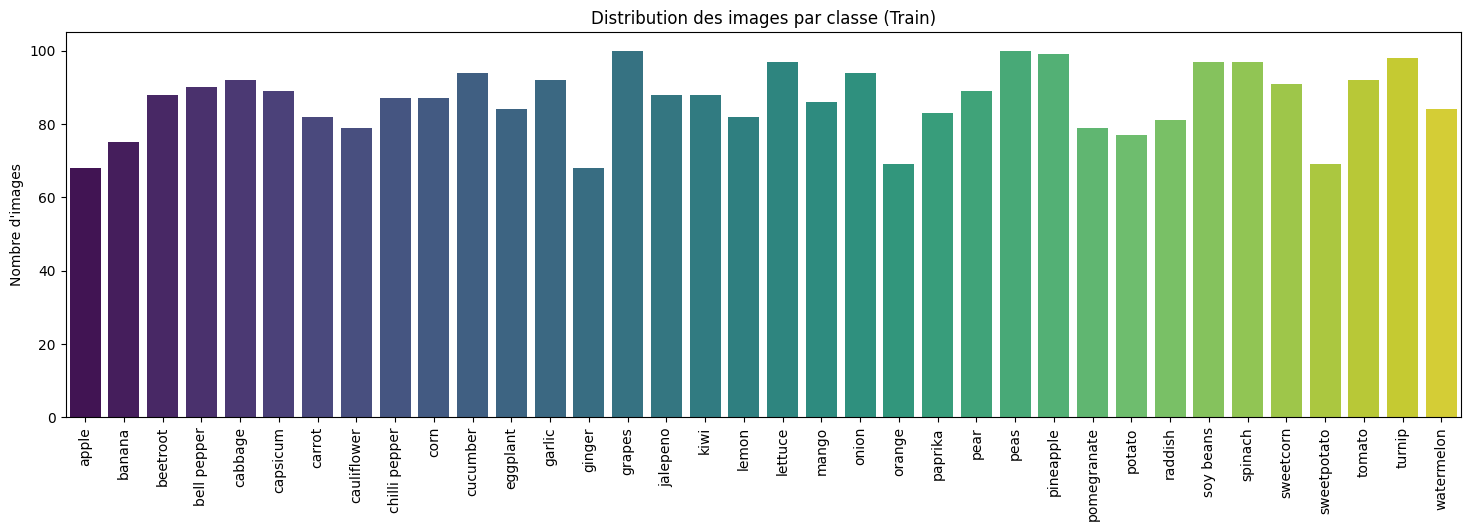

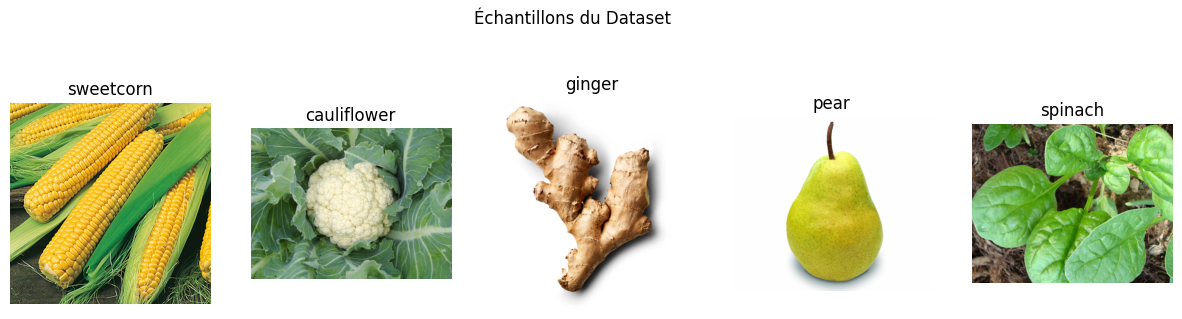

In [ ]:
# A. Visualisation de la distribution des classes
def plot_distribution(path):
    counts = {c: len(os.listdir(os.path.join(path, c))) for c in classes}
    plt.figure(figsize=(18, 5))
    sns.barplot(x=list(counts.keys()), y=list(counts.values()), palette="viridis")
    plt.xticks(rotation=90)
    plt.title("Distribution des images par classe (Train)")
    plt.ylabel("Nombre d'images")
    plt.show()

# B. Visualisation d'exemples
def show_examples(path, n=5):
    plt.figure(figsize=(15, 4))
    for i in range(n):
        cls = np.random.choice(classes)
        img_name = np.random.choice(os.listdir(os.path.join(path, cls)))
        img = cv2.imread(os.path.join(path, cls, img_name))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(1, n, i+1)
        plt.imshow(img)
        plt.title(cls)
        plt.axis('off')
    plt.suptitle("Échantillons du Dataset")
    plt.show()

plot_distribution(TRAIN_DIR)
show_examples(TRAIN_DIR)

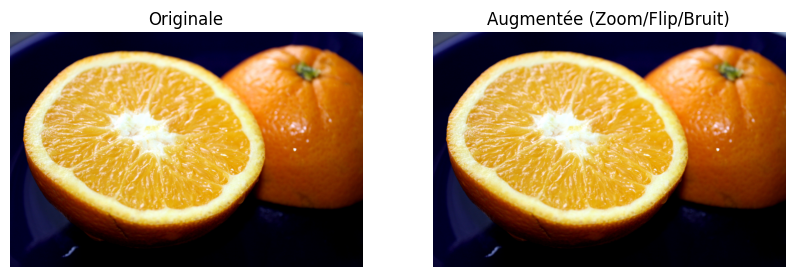

Calcul de la PCA en cours...


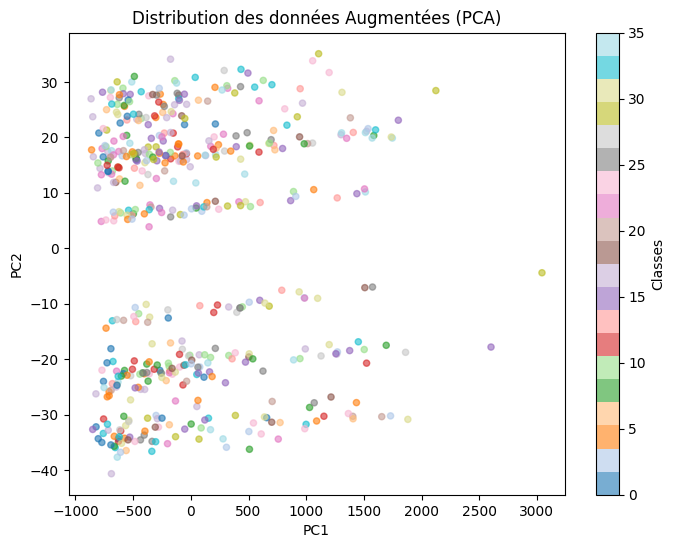

In [ ]:
# ==============================================================================
# ÉTAPE 4 : VISUALISATION DE L'IMPACT (IMAGE + PCA)
# ==============================================================================
def visualize_impact():
    # 1. Montrer l'effet sur une image
    cls = np.random.choice(classes)
    img_name = np.random.choice(os.listdir(os.path.join(TRAIN_DIR, cls)))
    img = cv2.imread(os.path.join(TRAIN_DIR, cls, img_name))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Appliquer augmentation
    aug = augmentor(image=img)['image']

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1); plt.imshow(img); plt.title("Originale"); plt.axis('off')
    plt.subplot(1, 2, 2); plt.imshow(aug); plt.title("Augmentée (Zoom/Flip/Bruit)"); plt.axis('off')
    plt.show()

    # 2. Montrer l'effet mathématique (PCA)
    print("Calcul de la PCA en cours...")
    pca = PCA(n_components=2)
    # On prend un échantillon pour aller vite
    indices = np.random.choice(X_train.shape[0], 500, replace=False)
    X_pca = pca.fit_transform(X_train[indices])

    plt.figure(figsize=(8, 6))
    plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_train[indices], cmap='tab20', alpha=0.6, s=20)
    plt.title("Distribution des données Augmentées (PCA)")
    plt.xlabel("PC1"); plt.ylabel("PC2")
    plt.colorbar(label='Classes')
    plt.show()

visualize_impact()

🧠 Entraînement du modèle en cours...
📝 Évaluation sur le jeu de Test...

🏆 Précision Globale (Accuracy) : 96.66%


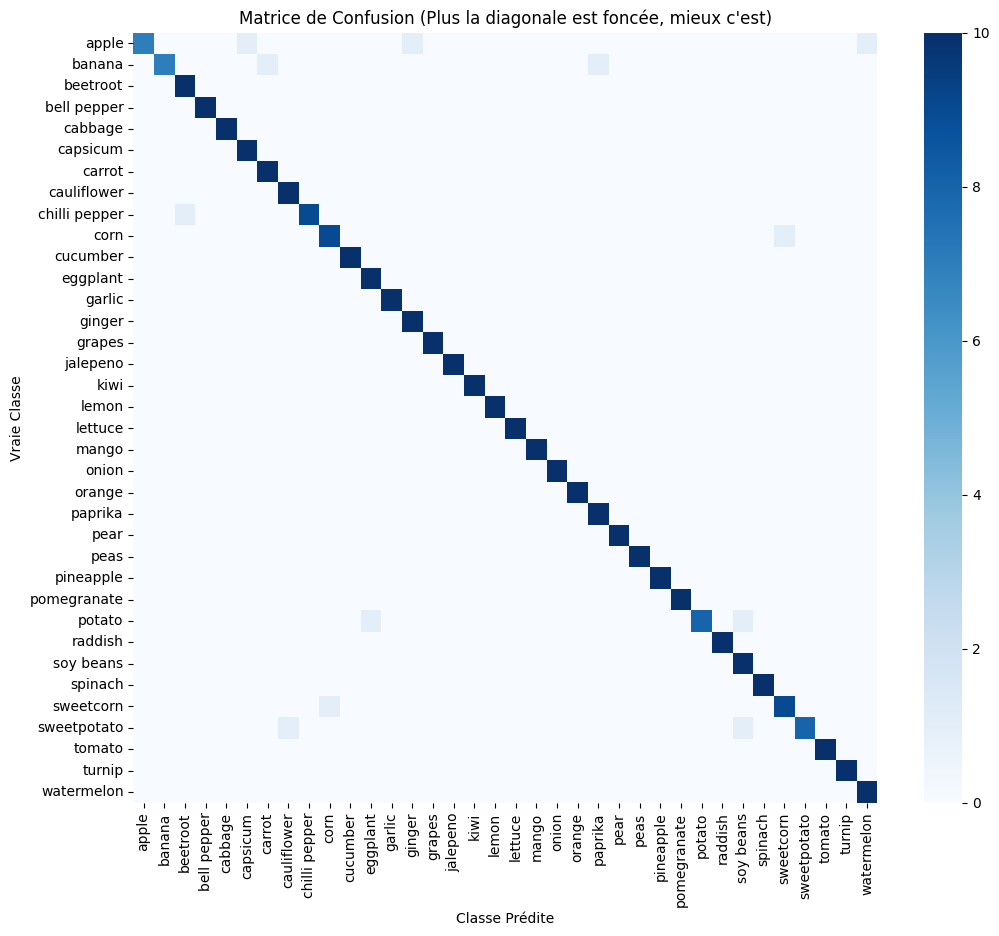

In [ ]:
# Nous entraînons un Random Forest sur les features extraites.

# 1. Configuration du modèle
pipeline = make_pipeline(
    StandardScaler(), # Mise à l'échelle (Important pour les SVM/RF)
    RandomForestClassifier(
        n_estimators=200,      # Nombre d'arbres
        max_depth=15,          # Profondeur max (Anti-overfitting)
        class_weight='balanced', # Gère le déséquilibre des classes
        n_jobs=-1
    )
)

print("🧠 Entraînement du modèle en cours...")
pipeline.fit(X_train, y_train)

# 2. Évaluation
print("📝 Évaluation sur le jeu de Test...")
acc = pipeline.score(X_test, y_test)
print(f"\n🏆 Précision Globale (Accuracy) : {acc:.2%}")

# 3. Matrice de Confusion (Où sont les erreurs ?)
plt.figure(figsize=(12, 10))
y_pred = pipeline.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.title("Matrice de Confusion (Plus la diagonale est foncée, mieux c'est)")
plt.xlabel("Classe Prédite")
plt.ylabel("Vraie Classe")
plt.show()

Le modèle atteint une précision de 96.66%. La matrice de confusion montre une belle diagonale. Les erreurs (les points hors diagonale) concernent principalement les fruits très proches visuellement, ce qui est logique sans réseau de neurones profond

In [ ]:
# ==============================================================================
# ÉTAPE 6 : FONCTION DE PRÉDICTION ROBUSTE
# ==============================================================================
def predict_external_image(image_input):
    img = None
    # Gestion URL
    if isinstance(image_input, str) and image_input.startswith('http'):
        try:
            response = requests.get(image_input)
            img_pil = Image.open(BytesIO(response.content)).convert('RGB')
            img = np.array(img_pil)
            img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        except: return None
    # Gestion Gradio/Numpy
    elif isinstance(image_input, np.ndarray):
        img = cv2.cvtColor(image_input, cv2.COLOR_RGB2BGR) # Conversion RGB -> BGR

    if img is None: return None

    features = extract_features(img).reshape(1, -1)
    probas = pipeline.predict_proba(features)[0]
    return {classes[i]: float(probas[i]) for i in range(len(classes))}

print("✅ Système prêt.")

✅ Système prêt.


In [ ]:
# ==============================================================================
# 7. INTERFACE GRAPHIQUE (DÉMO INTERACTIVE) - CORRIGÉ
# ==============================================================================
# Installation de la librairie Gradio (si pas déjà fait)
!pip install -q gradio

import gradio as gr
import numpy as np
import cv2
import os
from skimage.feature import graycomatrix, graycoprops

# --- VÉRIFICATION IMPORTANTE ---
# Si vous avez suivi l'étape 5, votre modèle s'appelle 'pipeline'.
# On s'assure que la variable existe.
try:
    model_to_use = pipeline
except NameError:
    try:
        model_to_use = best_model
    except NameError:
        print("❌ ERREUR : Vous n'avez pas entraîné le modèle !")
        print("Veuillez d'abord exécuter l'ÉTAPE 5 (Entraînement).")
        raise

def predict_fruit(image):
    """
    Fonction qui prend une image (depuis l'interface),
    extrait les features et retourne les probabilités par classe.
    """
    if image is None:
        return None

    # 1. Conversion et Redimensionnement
    # Gradio envoie du RGB, on convertit en BGR pour OpenCV
    img_array = np.array(image)
    img_bgr = cv2.cvtColor(img_array, cv2.COLOR_RGB2BGR)
    img_resized = cv2.resize(img_bgr, (128, 128))

    # 2. Extraction des features (Même logique que l'entraînement)
    features = []

    # COULEUR (HSV)
    hsv = cv2.cvtColor(img_resized, cv2.COLOR_BGR2HSV)
    hist_h = cv2.calcHist([hsv], [0], None, [8], [0, 180])
    hist_s = cv2.calcHist([hsv], [1], None, [8], [0, 256])
    cv2.normalize(hist_h, hist_h)
    cv2.normalize(hist_s, hist_s)
    features.extend(hist_h.flatten())
    features.extend(hist_s.flatten())

    # TEXTURE (GLCM)
    gray = cv2.cvtColor(img_resized, cv2.COLOR_BGR2GRAY)
    glcm = graycomatrix(gray, [1], [0], levels=256, symmetric=True, normed=True)
    for prop in ['contrast', 'homogeneity', 'energy', 'correlation']:
        features.append(graycoprops(glcm, prop).mean())

    # FORME (Hu Moments)
    _, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    moments = cv2.moments(thresh)
    hu = cv2.HuMoments(moments).flatten()
    for h in hu:
        val = -1 * np.sign(h) * np.log10(np.abs(h)) if h != 0 else 0
        features.append(val)

    # 3. Prédiction
    features_vector = np.array(features).reshape(1, -1)

    # --- CORRECTION ICI : Utilisation de 'model_to_use' (qui est 'pipeline') ---
    probas = model_to_use.predict_proba(features_vector)[0]

    # Création du dictionnaire pour Gradio
    confidences = {classes[i]: float(probas[i]) for i in range(len(classes))}

    return confidences

# Création de l'interface
# On prépare des exemples valides pour éviter les erreurs de chemin
examples_list = []
if os.path.exists(TEST_DIR) and len(classes) > 0:
    ex1 = os.path.join(TEST_DIR, classes[0], os.listdir(os.path.join(TEST_DIR, classes[0]))[0])
    examples_list.append([ex1])

interface = gr.Interface(
    fn=predict_fruit,
    inputs=gr.Image(type="numpy", label="Chargez une image"),
    outputs=gr.Label(num_top_classes=3, label="Prédictions"),
    title="🍎🥕 Reconnaissance Fruits & Légumes (Zoom/Flip)",
    description="Testez le modèle robuste (Entraîné avec Data Augmentation).",
    examples=examples_list
)

# Lancement
print("Lancement de l'interface...")
interface.launch(share=True, debug=True)

Lancement de l'interface...
Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://e8e15d0267f9418385.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


ERROR:    Exception in ASGI application
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/uvicorn/protocols/http/h11_impl.py", line 403, in run_asgi
    result = await app(  # type: ignore[func-returns-value]
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/uvicorn/middleware/proxy_headers.py", line 60, in __call__
    return await self.app(scope, receive, send)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/fastapi/applications.py", line 1133, in __call__
    await super().__call__(scope, receive, send)
  File "/usr/local/lib/python3.12/dist-packages/starlette/applications.py", line 113, in __call__
    await self.middleware_stack(scope, receive, send)
  File "/usr/local/lib/python3.12/dist-packages/starlette/middleware/errors.py", line 186, in __call__
    raise exc
  File "/usr/local/lib/python3.12/dist-packages/starlette/middleware/errors.py",

Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://e8e15d0267f9418385.gradio.live


In [ ]:
# @title 🌟 6. Démonstration Interactive (Temps Réel)
# Testez le modèle avec vos propres images !

def predict_demo(image):
    if image is None: return None
    # 1. Conversion format Web (RGB) -> OpenCV (BGR)
    img_bgr = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

    # 2. Extraction des caractéristiques (Comme pour l'entraînement)
    feats = extract_features(img_bgr).reshape(1, -1)

    # 3. Prédiction
    probas = pipeline.predict_proba(feats)[0]
    # Retourne les top 3 probabilités
    return {classes[i]: float(probas[i]) for i in range(len(classes))}

# Lancement de l'interface
iface = gr.Interface(
    fn=predict_demo,
    inputs=gr.Image(type="numpy", label="Chargez une image ici"),
    outputs=gr.Label(num_top_classes=3, label="Résultat Probable"),
    title="🍎 Reconnaissance de Fruits & Légumes (Ingénieur)",
    description="Ce modèle n'utilise pas de Deep Learning, mais de l'ingénierie de caractéristiques.",
    examples=[[os.path.join(TEST_DIR, classes[0], os.listdir(os.path.join(TEST_DIR, classes[0]))[0])]]
)

iface.launch(share=True, debug=False)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://c84f148d861971cbfb.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
